In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, regularizers, models, layers, callbacks
from sklearn.utils import class_weight

from prosenet import ProSeNet, PrototypeProjection, datasets, ops

In [2]:
# Dataset parameters

num_classes = 3
sequence_length = 200
num_features = 1

In [3]:
# Set any non-default args
new_rnn_args = {
    'layers' : [8],
    'layer_args' : {
        'dropout' : 0.1,
        'activity_regularizer' : regularizers.l2(0.1)    # Note: not in paper
    }
}

new_proto_args = {
    'dmin' : 2.0,
    'Ld' : 0.1, #0.1,
    'Lc' : 0.01,
    'Le' : 0.1
}

pnet = ProSeNet(input_shape=(sequence_length, num_features), 
                nclasses=num_classes, 
                k=12, 
                rnn_args=new_rnn_args,
                prototypes_args=new_proto_args,
                L1=0.1)

pnet.build( (None, sequence_length, num_features) )

pnet.summary()

Model: "pro_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 16)                640       
_________________________________________________________________
prototypes (Prototypes)      multiple                  192       
_________________________________________________________________
classifier (Dense)           multiple                  36        
Total params: 868
Trainable params: 868
Non-trainable params: 0
_________________________________________________________________


In [4]:
data = datasets.SyntheticSignalsDataset(examples_per_class=500)
data.load_data()

data.X_train.shape, data.y_train.shape, data.X_test.shape, data.y_test.shape

((1200, 200, 1), (1200, 3), (300, 200, 1), (300, 3))

In [5]:
train_gen = datasets.DataGenerator(data.X_train, data.y_train, batch_size=128)

test_gen = datasets.DataGenerator(data.X_test, data.y_test, batch_size=128)

class_weights = 1 - (np.bincount(np.argmax(data.y_train, 1)) / data.y_train.shape[0])

# Setting class 0 to 0.001, need to just get it to stop overfitting that class
#class_weights[0] = 0.0
class_weights

array([0.675     , 0.66083333, 0.66416667])

# First train just the `encoder`

In [6]:
x_encoded = pnet.encoder.output

pred = layers.Dense(3, activation='softmax')(x_encoded)

encoder_classifier = models.Model(inputs=pnet.encoder.input, outputs=pred)

encoder_classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 1)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 16)                640       
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________


In [7]:
rms = optimizers.RMSprop()

encoder_classifier.trainable = True

encoder_classifier.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])

encoder_classifier.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=25,
                   shuffle=False)

Epoch 1/25
10/10 [==============================] - 2s 215ms/step - loss: 1.1597 - accuracy: 0.2217 - val_loss: 1.1303 - val_accuracy: 0.3433
Epoch 2/25
10/10 [==============================] - 1s 53ms/step - loss: 1.1152 - accuracy: 0.4225 - val_loss: 1.0943 - val_accuracy: 0.5767
Epoch 3/25
10/10 [==============================] - 0s 48ms/step - loss: 1.0802 - accuracy: 0.6075 - val_loss: 1.0602 - val_accuracy: 0.7300
Epoch 4/25
10/10 [==============================] - 1s 53ms/step - loss: 1.0460 - accuracy: 0.7400 - val_loss: 1.0246 - val_accuracy: 0.7633
Epoch 5/25
10/10 [==============================] - 0s 48ms/step - loss: 1.0127 - accuracy: 0.7650 - val_loss: 0.9856 - val_accuracy: 0.7867
Epoch 6/25
10/10 [==============================] - 0s 49ms/step - loss: 0.9729 - accuracy: 0.7892 - val_loss: 0.9415 - val_accuracy: 0.8333
Epoch 7/25
10/10 [==============================] - 0s 49ms/step - loss: 0.9261 - accuracy: 0.8150 - val_loss: 0.8881 - val_accuracy: 0.8633
Epoch 8/25
1

# Now freeze the `encoder`

In [8]:
pnet.encoder.trainable = False

In [9]:
# Define come `Callback`s

init_lr = 0.01 # 1.0

def lr_schedule(epoch):
    if epoch <= 10:
        return init_lr
    else:
        return init_lr * 0.85**(epoch - 10)
    
lr_schedule = callbacks.LearningRateScheduler(lr_schedule)

early_stopping = callbacks.EarlyStopping(patience=3)

projection = PrototypeProjection(train_gen, freq=4)

In [23]:
sgd = optimizers.SGD(learning_rate=init_lr, clipnorm=5.0)

pnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

pnet.fit_generator(train_gen, 
                   validation_data=test_gen, 
                   epochs=15,
                   callbacks=[early_stopping, lr_schedule, projection],
                   shuffle=False)

Epoch 1/15
 9/10 [==========================>...] - ETA: 0s - loss: 6.2341 - accuracy: 0.6771
Computing prototype projection...
... assigned new prototypes from projections.
10/10 [==============================] - 1s 67ms/step - loss: 6.0861 - accuracy: 0.6750 - val_loss: 1.3491 - val_accuracy: 0.6333
Epoch 2/15
10/10 [==============================] - 1s 51ms/step - loss: 6.2482 - accuracy: 0.6742 - val_loss: 1.3358 - val_accuracy: 0.6333
Epoch 3/15
10/10 [==============================] - 1s 55ms/step - loss: 6.0423 - accuracy: 0.6750 - val_loss: 1.3250 - val_accuracy: 0.6333
Epoch 4/15
10/10 [==============================] - 1s 54ms/step - loss: 5.9573 - accuracy: 0.6750 - val_loss: 1.3142 - val_accuracy: 0.6333
Epoch 5/15
 9/10 [==========================>...] - ETA: 0s - loss: 6.0380 - accuracy: 0.6745
Computing prototype projection...
... assigned new prototypes from projections.
10/10 [==============================] - 1s 71ms/step - loss: 5.9047 - accuracy: 0.6733 - val_loss:

# Diagnostics

In [24]:
# Encoding layer(s) output
pnet.encoder.predict(data.X_train[np.newaxis, 0], batch_size=1)

array([[ 0.30777535,  0.18210857, -0.1733888 , -0.25231943, -0.2078278 ,
        -0.2570162 , -0.20708437, -0.2552549 ,  0.26357135,  0.38411033,
         0.26860392, -0.34871837,  0.58411616, -0.39913175,  0.42202175,
         0.28159726]], dtype=float32)

-0.6155657 1.0


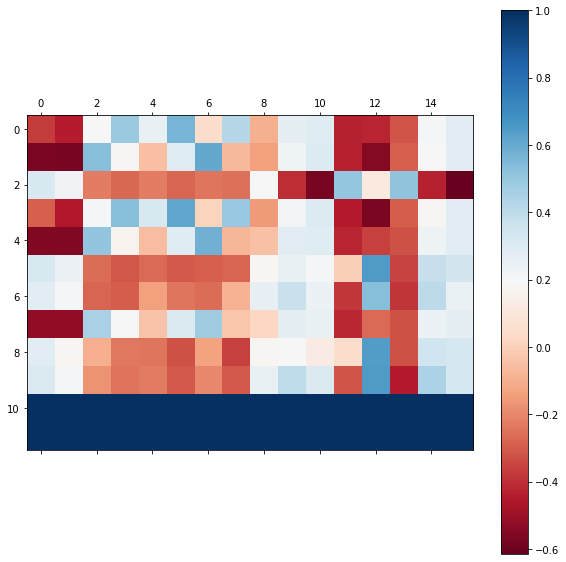

In [25]:
# Prototype layer weights
protos = np.squeeze(pnet.prototypes_layer.weights[0].numpy())
print(protos.min(), protos.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(protos, cmap=plt.cm.RdBu)
fig.colorbar(cax, ax=ax)

0.0 0.6225273


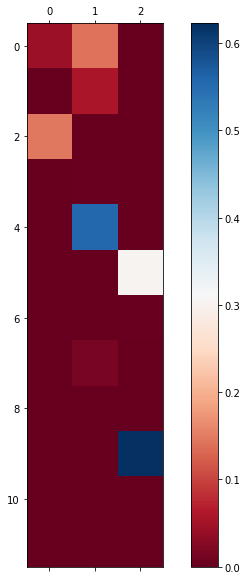

In [26]:
pred_weights = np.squeeze(pnet.classifier.weights[0].numpy())
print(pred_weights.min(), pred_weights.max())

fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(pred_weights, cmap=plt.cm.RdBu)
fig.colorbar(cax)

In [14]:
pnet.predict(data.X_train[:3,:], batch_size=1)

array([[0.25979257, 0.25043958, 0.48976782],
       [0.26047394, 0.2519256 , 0.4876005 ],
       [0.32998195, 0.36690077, 0.30311728]], dtype=float32)

In [15]:
data.y_train[:3]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [16]:
pnet.predict(data.X_test[-3:,:], batch_size=1)

array([[0.3331025 , 0.32186475, 0.34503278],
       [0.32999173, 0.32029146, 0.34971684],
       [0.33184165, 0.32034132, 0.347817  ]], dtype=float32)

In [17]:
data.y_test[-3:]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

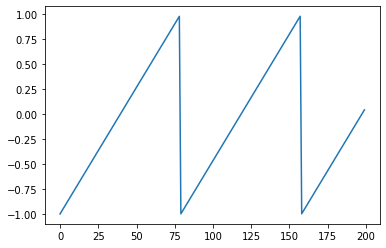

In [18]:
plt.plot(np.arange(200), data.X_train[-2])

In [27]:
pnet.classifier.weights[0]

<tf.Variable 'classifier/kernel:0' shape=(12, 3) dtype=float32, numpy=
array([[4.4596214e-02, 1.4278108e-01, 0.0000000e+00],
       [0.0000000e+00, 5.6222707e-02, 0.0000000e+00],
       [1.4716601e-01, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 2.6920002e-03, 0.0000000e+00],
       [0.0000000e+00, 5.5495358e-01, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 3.0252284e-01],
       [0.0000000e+00, 0.0000000e+00, 4.8569152e-03],
       [0.0000000e+00, 1.5118364e-02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 4.6219071e-04],
       [0.0000000e+00, 0.0000000e+00, 6.2252730e-01],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [20]:
encoder_classifier.layers[-1].weights

[<tf.Variable 'dense/kernel:0' shape=(16, 3) dtype=float32, numpy=
 array([[ 0.26235294, -0.72868234,  0.2940476 ],
        [ 0.4007082 , -0.5022236 ,  0.7194336 ],
        [-0.42036492,  0.15653232, -0.3789319 ],
        [-0.62114495,  0.654611  ,  0.11580774],
        [-0.21359725,  0.36978152, -0.559814  ],
        [-0.28852865,  0.4597415 , -0.26221383],
        [-0.16463281,  0.6001825 , -0.00912399],
        [ 0.15377867,  0.6270688 ,  0.02343298],
        [ 0.00737225, -0.37492007, -0.02500223],
        [-0.22648765,  0.61171675,  0.5161362 ],
        [-0.54430336,  0.6570726 ,  0.41015047],
        [ 0.69531476, -0.5288958 , -0.05385625],
        [-0.34874824, -0.5706958 ,  0.42223084],
        [ 0.501098  ,  0.23402044, -0.06349454],
        [-0.6103677 , -0.35336393, -0.0624767 ],
        [-0.6890278 ,  0.36532387,  0.31711188]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(3,) dtype=float32, numpy=array([-0.11323137, -0.08032209,  0.13299073], dtype=float32)>]

In [21]:
pnet.prototypes_layer._diversity_term()

<tf.Tensor: id=383793, shape=(), dtype=float32, numpy=24.579487>

In [22]:
pnet.encoder.predict(data.X_train[np.newaxis, 0], batch_size=1)

array([[ 0.30777535,  0.18210857, -0.1733888 , -0.25231943, -0.2078278 ,
        -0.2570162 , -0.20708437, -0.2552549 ,  0.26357135,  0.38411033,
         0.26860392, -0.34871837,  0.58411616, -0.39913175,  0.42202175,
         0.28159726]], dtype=float32)

In [33]:
similarities = pnet.similarity_vector(data.X_train[1:3]).numpy()

In [31]:
data.y_train[1:3]

array([[0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [34]:
similarities

array([[0.12440617, 0.10812616, 0.11286819, 0.10753155, 0.12717317,
        0.7322669 , 0.72014695, 0.14373279, 0.64191914, 0.80144465,
        0.01879735, 0.01879735],
       [0.91263515, 0.39591092, 0.0629258 , 0.76952124, 0.40139166,
        0.10628334, 0.1316222 , 0.43894532, 0.11387581, 0.11572197,
        0.01788983, 0.01788983]], dtype=float32)

In [36]:
np.argmax(pnet.classifier.weights[0].numpy(), -1)

array([1, 1, 0, 1, 1, 2, 2, 1, 2, 2, 0, 0])